In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
print("✅ All libraries imported.")


ModuleNotFoundError: No module named 'seaborn'

In [5]:
ratings = pd.read_csv("ratings.csv")[['userId', 'movieId', 'rating']].sample(n=50000, random_state=42)
movies = pd.read_csv("movies.csv")



ratings['userId'] = ratings['userId'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)
movies['movieId'] = movies['movieId'].astype(str)


reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings, reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print("✅ Data loaded and processed.")

✅ Data loaded and processed.


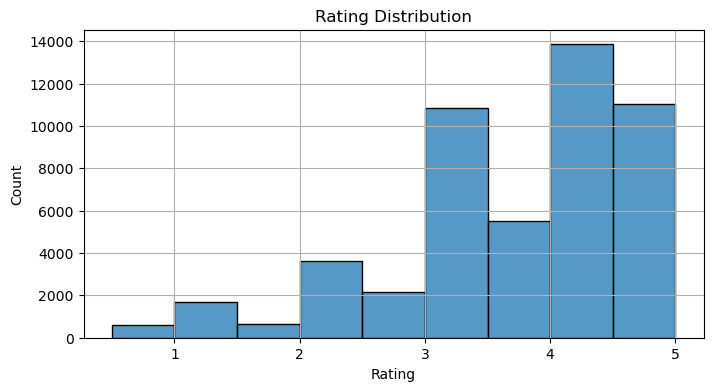

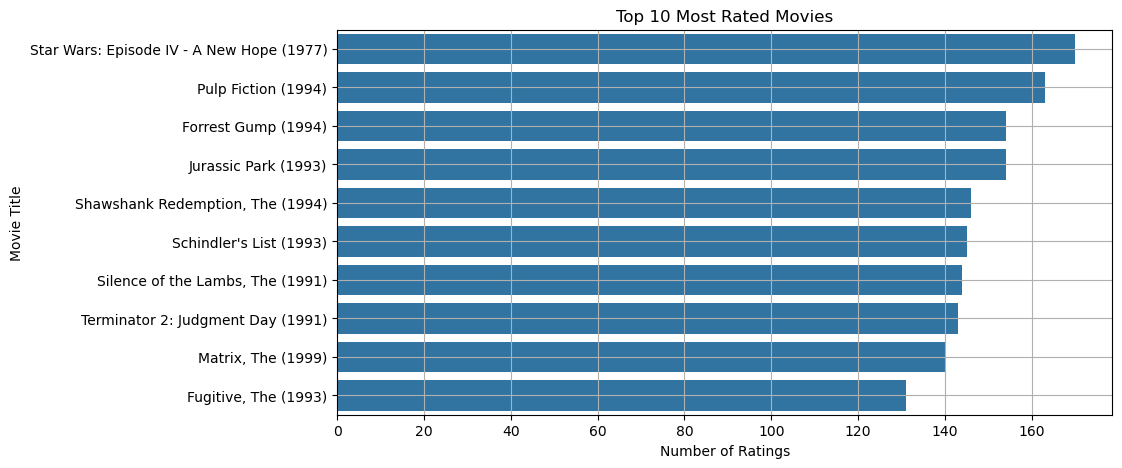

In [7]:
plt.figure(figsize=(8, 4))
sns.histplot(ratings['rating'], bins=9, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

top_rated = ratings['movieId'].value_counts().head(10).index
top_titles = movies[movies['movieId'].isin(top_rated)][['movieId', 'title']].set_index('movieId')
rating_counts = ratings['movieId'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=rating_counts.values, y=top_titles.loc[rating_counts.index]['title'])
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.grid(True)
plt.show()


In [9]:
svd_model = SVD()
svd_model.fit(trainset)
svd_preds = svd_model.test(testset)
svd_rmse = accuracy.rmse(svd_preds)
svd_mae = accuracy.mae(svd_preds)


knn_model = KNNBasic()
knn_model.fit(trainset)
knn_preds = knn_model.test(testset)
knn_rmse = accuracy.rmse(knn_preds)
knn_mae = accuracy.mae(knn_preds)


print(f"SVD      - RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")
print(f"KNNBasic - RMSE: {knn_rmse:.4f}, MAE: {knn_mae:.4f}")


model = svd_model if svd_rmse < knn_rmse else knn_model
print("✅ Best model selected for recommendations.")


RMSE: 0.9689
MAE:  0.7547
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0415
MAE:  0.8287
SVD      - RMSE: 0.9689, MAE: 0.7547
KNNBasic - RMSE: 1.0415, MAE: 0.8287
✅ Best model selected for recommendations.


In [23]:
def extract_genres(movies_df):
    genres = set()
    for g in movies_df['genres']:
        if isinstance(g, str):
            genres.update(g.split('|'))
    return sorted(list(genres - {'(no genres listed)'}))

GENRES = extract_genres(movies)
INDIAN_KEYWORDS = ['india', 'bollywood', 'hindi', 'tamil', 'telugu', 'bolly', 'kollywood', 'mollywood']

def is_indian_movie(title):
    return isinstance(title, str) and any(k in title.lower() for k in INDIAN_KEYWORDS)

def recommend_movies_by_genre(genre, prioritize_indian=False, n=5):
    user_id = random.choice(ratings['userId'].unique())
    genre_movies = movies[movies['genres'].str.contains(genre, na=False)]
    if prioritize_indian:
        genre_movies = genre_movies[genre_movies['title'].apply(is_indian_movie)]
    rated = ratings[ratings['userId'] == user_id]['movieId']
    genre_movies = genre_movies[~genre_movies['movieId'].isin(rated)]
    predictions = []
    for _, m in genre_movies.iterrows():
        try:
            pred = model.predict(user_id, m['movieId']).est
            predictions.append((m['title'], round(pred, 2)))
        except:
            continue
    return sorted(predictions, key=lambda x: x[1], reverse=True)[:n]


In [27]:
user_name = input("Enter your name: ")
selected_genre = input(f"Choose genre ({', '.join(GENRES[:10])}...): ")
prioritize = input("Prioritize Indian movies? (yes/no): ").lower() == 'yes'
results = recommend_movies_by_genre(selected_genre, prioritize)
print(f"￿ {user_name}'s Top {selected_genre} Recommendations:\n")
for title, score in results:
    print(f"• {title} - ￿ {score}")

Enter your name:  Avv
Choose genre (Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir...):  Action
Prioritize Indian movies? (yes/no):  No


￿ Avv's Top Action Recommendations:

• Apocalypse Now (1979) - ￿ 4.51
• Dark Knight, The (2008) - ￿ 4.51
• Seven Samurai (Shichinin no samurai) (1954) - ￿ 4.47
• Inception (2010) - ￿ 4.41
• Star Wars: Episode IV - A New Hope (1977) - ￿ 4.33
